In [1]:
import numpy as np
from scipy.integrate import quad_vec

# SIMP 

Solid Isotropic Microstructure with Penalization for intermediate densities (Тверда ізотропна мікроструктура з пеналізацією для проміжних щільностей) -- метод, який робить оптимізацію через пошук градієнтів, які контролюється за параметром штрафу.

Цей метод є досить простим в імплементації й використанні, може бути покращений для багатопоточної обробки й використовується для топологічної оптимізації (в основному для мінімізації структурних деталей). Але він має проблему, як западання градієнтів, через що результат буде не дуже точним.

Формула до цього методу наведена нижче. Параметри:
- p -- штрафне значення методу, яке використовується для пошуку градієнтів
- pe або rho -- відносні щільності, якими і є наші градієнти
- ue -- вектор вузлового зміщення
- Ke -- жорсткість елементу 

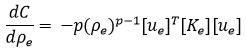
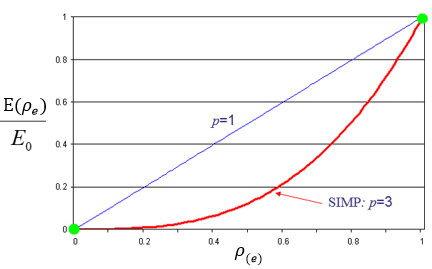

In [73]:
def simp(
    rho: np.matrix,
    Kc: np.matrix,
    k0: np.float64,
    obj_func,
    args,
    p = 3,
    iterations = 20,
    learning_rate = 0.1
):
    prep_compliance = 0

    for i in range(iterations):
        args |= {"rho": rho}
        Kc, compliance = obj_func(coeff=p, kc=Kc, **args)

        dC_drho = -p * rho ** (p - 1) * k0 * compliance / (compliance + 1e-6)
        rho += learning_rate * dC_drho.reshape(rho.shape)

        rho = np.clip(rho, 0.2, 1)

        print(f"it: {i} {compliance}")

        if np.abs(prep_compliance - compliance) < 0.0001 or compliance < 0.0001:
            break
        else:
            prep_compliance = compliance

    return Kc, compliance

In [74]:
# Darcy

def inlet_pressure_load(
    k: np.matrix, # Permeability matrix
    p: np.float64 # Nodal pressure in the structure
):
    return k * p


# flow solution
def nodal_pressure(
    k: np.matrix, # Permeability matrix
    f: np.matrix # Pressure load at the inlet
):
    return np.dot(1 / k, f)


def fluid_velocity(
    k: np.float64, # Fluid permeability
    u: np.float64, # Fluid dynamic viscosity
    p_nodes: np.matrix, # Pressure differential
    b: np.matrix
):
    return - k / u * b * p_nodes


def fluid_velocity_e(
    k: np.float64, # Fluid permeability
    u: np.float64, # Fluid dynamic viscosity
    b_dif: np.float64, # Differential of the shape function
    p_e: np.float64 # Nodal pressure in the element
):
    return - k / u * b_dif * p_e


def conductivity_matrix_node(
    x: np.float64,
    # y: np.float64,
    k: np.float64, # Thermal conductivity
    b: np.matrix # Differential of the shape function
):
    # return k * np.dot(b.T, b)
    return k * b.T * b


def conductivity_matrix(
    ne: np.float64, # Total number of elements
    k: np.float64, # Thermal conductivity
    b: np.matrix, # Differential of the shape function
    x_l: np.float64,
    x_u: np.float64,
    dm = 3
):
    b_shape = b.shape[0]
    kc = np.zeros([b_shape] * dm)
    # for n in range(ne):
    res, _ = quad_vec(conductivity_matrix_node, x_l, x_u, args=(k, b))
    kc += res

    return kc


def convection_matrix_node(
    x: np.float64,
    # y: np.float64,
    rho: np.float64, # Density
    cp: np.float64, # Specific heat capacity
    u_e: np.float64, # Element flow velocity from Darcy’s Law
    n_t: np.matrix, # Enhanced shape function
    b: np.matrix # Differential of the shape function
):
    # return rho * cp * np.dot(n_t.T, b) * u_e
    return rho * cp * n_t.T * b * u_e


def convection_matrix(
    ne: np.float64, # Total number of elements
    rho: np.float64, # Density
    cp: np.float64, # Specific heat capacity
    u_e: np.float64, # Element flow velocity from Darcy’s Law
    n_t: np.matrix, # Enhanced shape function
    b: np.matrix, # Differential of the shape function
    x_l: np.float64,
    x_u: np.float64,
    dm = 3
):  
    n_t_shape = n_t.shape[1]
    cpm = np.zeros([n_t_shape] * dm)
    # for n in range(ne):
    res, _ = quad_vec(convection_matrix_node, x_l, x_u, args=(rho, cp, u_e, n_t, b))
    cpm += res

    return cpm


def thermal_steady_state_heat_transfer(
    kc: np.matrix, # Conductivity Matrix
    cp: np.matrix, # Convection Matrix
    t: np.matrix # Nodal temperature matrix
):
    # return np.dot(kc + cp, t)
    return (kc + cp) * t


def global_thermal_compilance(
    t: np.matrix, # Nodal temperature matrix
    f: np.matrix # Termal steady-state heat transfer
):
    return 0.5 * np.dot(t.T.flatten(), f.flatten())#.item()


def update_conductivity_matrix(ne, k0, rho, coeff, b, x_l, x_u, dm = 3):
    ke = rho ** coeff * k0
    kc = conductivity_matrix(ne, ke, b, x_l, x_u, dm)
    return kc

In [75]:
class Darcy:
    def __init__(
        self, 
        rho, 
        cp, 
        k_thermal, 
        mu, 
        k_fluid, 
        ne, 
        x_l, 
        x_u, 
        p_init, 
        t_init,
        b,
        n_tilde,
        dm = 3
        # k0
    ):
        self.rho = rho
        self.cp = cp
        self.k_thermal = k_thermal
        self.mu = mu
        self.k_fluid = k_fluid
        self.ne = ne
        self.x_l = x_l
        self.x_u = x_u
        self.p_init = p_init
        self.t_init = t_init
        self.b = b
        self.n_tilde = n_tilde
        self.dm = dm
        # self.k0 = k0

        self.f_inlet = inlet_pressure_load(k_fluid, p_init)
        self.p_nodes = nodal_pressure(k_fluid, self.f_inlet)
        # self.p_diff = np.diff(self.p_nodes, axis=0)
        self.u_flow = fluid_velocity(k_fluid, mu, self.p_nodes, self.b)
        self.Cp = convection_matrix(
            ne, 
            rho, 
            cp, 
            self.u_flow,#.mean(), 
            self.n_tilde, 
            self.b, 
            x_l, 
            x_u,
            self.dm
        )


    def __call__(self, rho, coeff, kc):
        self.f_inlet = inlet_pressure_load(self.k_fluid, self.p_nodes)
        self.p_nodes = nodal_pressure(self.k_fluid, self.f_inlet)
        # self.p_diff = np.diff(self.p_nodes, axis=0)
        self.u_flow = fluid_velocity(self.k_fluid, self.mu, self.p_nodes, self.b)
        self.Cp = convection_matrix(
            self.ne, 
            rho, 
            self.cp, 
            self.u_flow,#.mean(), 
            kc, 
            self.b, 
            self.x_l, 
            self.x_u,
            self.dm
        )
        Kc = update_conductivity_matrix(
            self.ne, self.k_thermal, rho, coeff, self.b, self.x_l, self.x_u, self.dm
        )
        t_final = thermal_steady_state_heat_transfer(Kc, self.Cp, self.t_init)
        compliance = global_thermal_compilance(self.t_init, t_final.reshape([self.ne] * self.dm))

        return Kc, compliance

In [81]:
ne = 100  # кількість елементів в кожному вимірі (10x10x10)

rho = 1000  # густина рідини
cp = 4184   # питома теплоємність
k_thermal = 0.6  # теплопровідність
mu = 0.001  # динамічна в'язкість
k_fluid = 1e-12  # проникність рідини

# Параметри області
x_lower, x_upper = 0, 1  # межі області

# Початковий розподіл тиску (3D масив)
p_initial = np.full((ne, ne, ne), 101325)  # тиск в Паскалях

# Початкова температура (3D масив)
t_initial = np.full((ne, ne, ne), 300)  # температура в Кельвінах

# Матриця похідних функцій форми B і розширена форма N_tilde
B = np.ones((ne, ne, ne))  # спрощена початкова матриця B
N_tilde = np.zeros((ne, ne, ne))
N_tilde[0:10, 0:10, 0:10] = 1  # визначена область зі значеннями

# Ініціалізація об'єкта Darcy
darcy = Darcy(rho, cp, k_thermal, mu, k_fluid, ne, x_lower, x_upper, p_initial, t_initial, B, N_tilde)

# Початкове значення для оптимізованої змінної щільності rho
rho = np.random.uniform(0.1, 1, size=(ne, ne, ne))
Kc, comp = simp(rho, darcy.n_tilde, darcy.k_thermal, darcy, {}, iterations=200, p=4, learning_rate=0.1)

it: 0 5997770388.512108
it: 1 1648485873.3083565
it: 2 1298104029.6581485
it: 3 988927532.7996925
it: 4 778624508.099447
it: 5 631338021.5997202
it: 6 524122082.68027425
it: 7 443426452.3420267
it: 8 380993691.2775749
it: 9 331576778.15825266
it: 10 291709688.0258179
it: 11 259024047.05163002
it: 12 231853628.24676874
it: 13 208996467.5572092
it: 14 189566415.2635517
it: 15 172897165.8128971
it: 16 158479809.8601247
it: 17 145919317.50286657
it: 18 134905191.77266747
it: 19 125190320.40943947
it: 20 116575606.27904357
it: 21 108899812.12604898
it: 22 102030815.26952064
it: 23 95859275.94291133
it: 24 90294296.11548512
it: 25 85259668.69333272
it: 26 80691051.41246253
it: 27 76533950.32492323
it: 28 72742015.63501461
it: 29 69275482.04254863
it: 30 66100251.84803578
it: 31 63187010.90954444
it: 32 60510170.63668275
it: 33 58047886.12667471
it: 34 55781075.9937708
it: 35 53692856.09944028
it: 36 51769139.61071867
it: 37 49997772.26274783
it: 38 48368585.99297904
it: 39 46872585.60911956


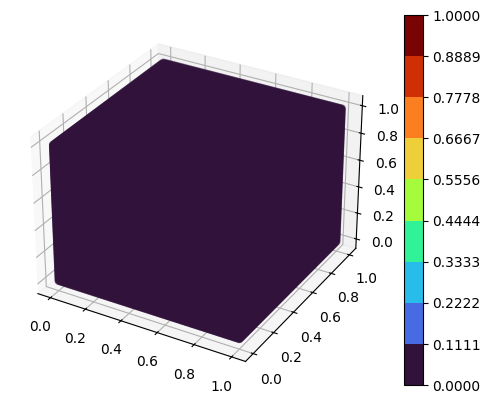

In [83]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.mplot3d import Axes3D

c = np.tile(Kc.ravel()[:, None], [1, 3])

vKc = Kc.copy()
# vKc[vKc < 0.1] = np.nan

nx, ny, nz = (ne, ne, ne)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
z = np.linspace(0, 1, nz)
xv, yv, zv = np.meshgrid(x, y,z)

bounds = np.linspace(0,1, 10)
norm = BoundaryNorm(bounds, len(bounds) - 1)
cmap = plt.get_cmap('turbo', len(bounds) - 1)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
scat = ax.scatter(xv, yv, zv, c=vKc, marker='o', cmap=cmap, norm=norm)
cbar = plt.colorbar(scat, ax=ax, ticks=bounds, format='%.4f')
plt.show()

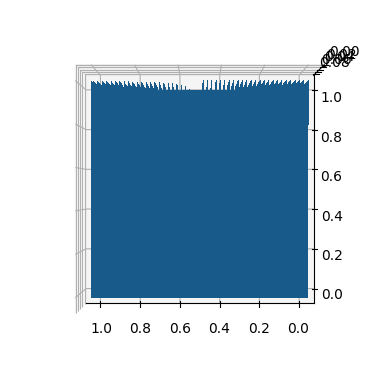

In [84]:
xvv = np.concat([xv[:, :, i] for i in range(10)])
yvv = np.concat([yv[:, :, i] for i in range(10)])
zvv = np.concat([zv[:, :, i] for i in range(10)])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(xvv, yvv, zvv, linewidth=0, antialiased=False)
ax.view_init(azim=90, elev=-90)
plt.show()

In [85]:
with open("result.obj", 'w') as f:
    vertex_map = {}
    current_vertex_index = 1
    
    for i in range(xv.shape[0]):
        for j in range(xv.shape[1]):
            for k in range(xv.shape[2]):
                if not np.isnan(vKc[i, j, k]):
                    f.write(f"v {xv[i,j,k]} {yv[i,j,k]} {zv[i,j,k]}\n")
                    vertex_map[(i, j, k)] = current_vertex_index
                    current_vertex_index += 1
        
    for i in range(xv.shape[0] - 1):
        for j in range(xv.shape[1] - 1):
            for k in range(xv.shape[2] - 1):
                if (i, j, k) in vertex_map and \
                   (i+1, j, k) in vertex_map and \
                   (i+1, j+1, k) in vertex_map and \
                   (i, j+1, k) in vertex_map:
                    v1 = vertex_map[(i, j, k)]
                    v2 = vertex_map[(i+1, j, k)]
                    v3 = vertex_map[(i+1, j+1, k)]
                    v4 = vertex_map[(i, j+1, k)]
                    f.write(f"f {v1} {v2} {v3} {v4}\n")  

In [86]:
Kc

array([[[0.00096, 0.00096, 0.00096, ..., 0.00096, 0.00096, 0.00096],
        [0.00096, 0.00096, 0.00096, ..., 0.00096, 0.00096, 0.00096],
        [0.00096, 0.00096, 0.00096, ..., 0.00096, 0.00096, 0.00096],
        ...,
        [0.00096, 0.00096, 0.00096, ..., 0.00096, 0.00096, 0.00096],
        [0.00096, 0.00096, 0.00096, ..., 0.00096, 0.00096, 0.00096],
        [0.00096, 0.00096, 0.00096, ..., 0.00096, 0.00096, 0.00096]],

       [[0.00096, 0.00096, 0.00096, ..., 0.00096, 0.00096, 0.00096],
        [0.00096, 0.00096, 0.00096, ..., 0.00096, 0.00096, 0.00096],
        [0.00096, 0.00096, 0.00096, ..., 0.00096, 0.00096, 0.00096],
        ...,
        [0.00096, 0.00096, 0.00096, ..., 0.00096, 0.00096, 0.00096],
        [0.00096, 0.00096, 0.00096, ..., 0.00096, 0.00096, 0.00096],
        [0.00096, 0.00096, 0.00096, ..., 0.00096, 0.00096, 0.00096]],

       [[0.00096, 0.00096, 0.00096, ..., 0.00096, 0.00096, 0.00096],
        [0.00096, 0.00096, 0.00096, ..., 0.00096, 0.00096, 0.00096],
    